In [1]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [2]:
import numpy as np

In [3]:
sys.path.append('../UmbrellaGen')
import grid_gen

### Define the grid dimensions and Umbrella Valence you want

In [4]:
degree = 3 # 3 for TriUmbrellas, 4 for QuadUmbrellas, 6 for HexBrellas
rows = 5 # please make sure rows >=2
cols = 5 # please make sure cols >=2

In [5]:
numUmbrellas = 0
if degree == 3:
    numUmbrellas = (rows * 2) * cols
elif degree == 4 or degree == 6:
    numUmbrellas = rows * cols

### Define your favorite height, material and cross-section function! Umbrellas are sequenced row-wise if you use the grid

In [6]:
def myHeightFunc(numUmbrellas): 
    heights = [1] * numUmbrellas # Scale Factor of heights. Set minHeight to your desired minimum absolute height.
    for uid in range(numUmbrellas):
        # heights[uid] += (0.1 * uid**1.6 + 0.1 *(numUmbrellas - 1 - uid)**1.6)
        heights[uid] += (0.01 * uid**2 + 0.01 *(numUmbrellas - 1 - uid)**2)
    heights = [h/min(heights) for h in heights]
    return heights

# # Lets not use this for now. Not essential for our project immediately
# def myMaterialFunc(numUmbrellas):
#     plate_E, plate_nu, plate_thickness, plate_width = [1400 * 10, 0.35, 3.0, 5.0]
#     E = [1400] * numUmbrellas #Default values for uniform material umbrellas
#     nu = [0.35] * numUmbrellas
#     thickness = [3.0] * numUmbrellas
#     width = [5.0] * numUmbrellas
    
#     # Write your material function here dependent on UmbrellaID (uid). In the visualization below the colormap (viridis) will help you visualize the IDs. They are sequenced row-wise
#     #-------
#     for uid in range(numUmbrellas):
#         # E[uid] += -2000 + 0.05 * (  uid ** 3 + (numUmbrellas - 1 - uid)**3 )
#         # nu[uid] += 0.01 * uid
#         thickness[uid] += 0.1 * uid
#         width[uid] += 0.1 * uid
#     #-------
        
        
#     material_params = np.zeros((1 + 4 * (numUmbrellas + 1)))
#     material_params[0] = numUmbrellas + 1
#     material_params[1::4] = E + [plate_E]
#     material_params[2::4] = nu + [plate_nu]
#     material_params[3::4] = thickness + [plate_thickness]
#     material_params[4::4] = width + [plate_width]
    
#     return material_params
    

### Compute Geometry with Regular Grid

In [7]:
# The height function is a scaling function relative to the minHeight
minHeight = 64
grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight)

### Compute Geometry with Custom Equilateral Tiling with triangle

In [8]:
import mesh
base_mesh = mesh.Mesh("../../data/plane_equi.obj")
V, F = base_mesh.vertices(), base_mesh.elements()
V_3d = np.zeros((len(V), 3))
V_3d[:, :2] = V
edge_length = np.linalg.norm(V_3d[F][0, 0] - V_3d[F][0, 1])
numUmbrellas = len(F)

In [9]:
grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight, base_mesh = (V_3d.tolist(),F.tolist()), edge_length=edge_length)

### Initialization of Umbrella Class

In [10]:
name = 'grid_dump'
input_path = '../UmbrellaGen/{}.json.gz'.format(name)
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(input_path, handleBoundary = False, isHex = (degree == 6), use_target_surface = False)
# Can set use_target_surface = True to add target_mesh to the curr_um class for target attraction during deployment as well as inverse design

In [11]:
target_height_multiplier

5

In [12]:
# The deployment spacing is computed as plate_thickness * target_height_multiplier inside the subsequent deployment call. 
# target_height_multiplier can be a scalar as above or a vector (np.array) of size numUmbrellas

In [13]:
rod_colors = get_color_field(curr_um, input_data, uidBased = False) 

lview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
lview.update(scalarField = rod_colors)
lview.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

### Deploy umbrellaMesh - Go through configuration.py to get some idea about deployment hyper-params. It's okay if you do not understand everything there

In [14]:
success, eqays = deploy_umbrella_pin_rigid_motion(curr_um, plate_thickness_scaled, target_height_multiplier, lview, rod_colors, analysis = True, dep_weights=np.logspace(-4, 0, 5))

In [15]:
success

True

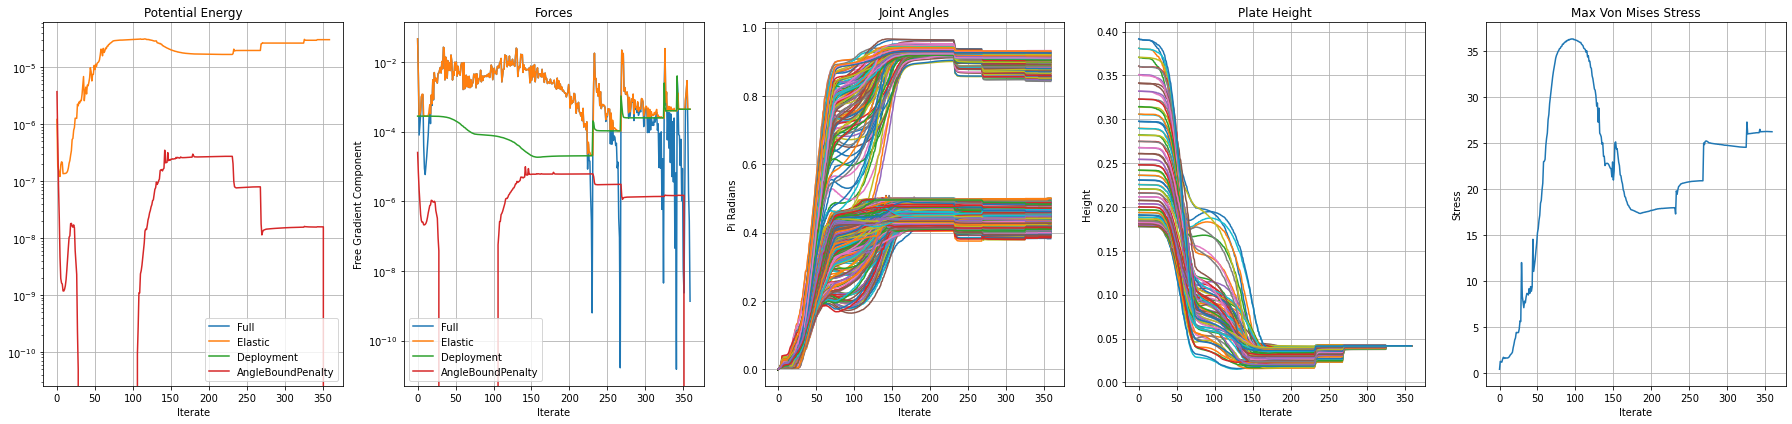

In [16]:
eqays.plot()

## Stress Visualization

In [17]:

sview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
sview.update(scalarField = curr_um.maxVonMisesStresses())
sview.update(scalarField = curr_um.maxBendingStresses())
sview.update(scalarField = curr_um.twistingStresses())
sview.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…